<a href="https://colab.research.google.com/github/mrpiay/mrbeam/blob/main/mrbeam_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STEP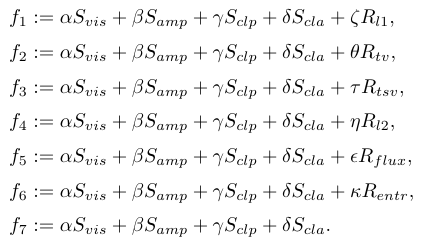#1: install mrbeam framework**

In [ ]:
! git clone https://github.com/mrpiay/mrbeam.git

In [ ]:
! wget https://github.com/liamedeiros/ehtplot/archive/refs/heads/master.zip
! unzip master.zip -d .
! wget https://github.com/achael/eht-imaging/archive/refs/tags/v1.2.7.zip
! unzip v1.2.7.zip -d .
! pip install pygmo
! pip install ./ehtplot-master
! pip install ./eht-imaging-1.2.7
! pip install ./mrbeam/mr_beam/itreg
! pip install ./mrbeam/mr_beam/libwise-0.4.7-light
! pip install ./mrbeam/mr_beam/MSI
! pip install ./mrbeam/mr_beam/imagingbase
! pip install ./mrbeam/mr_beam/ga

### **Restart session in Colab: Runtime -> Restart session (Ctrl+M)**









# **STEP #2: create a user defined MOP for pygmo**

In [ ]:
import pygmo as pg
import numpy as np
import GA.solver as solver
from GA.problems import EHT
import sys
import ehtim as eh
import matplotlib.pyplot as plt

#mrpiay
import json
import pprint
#mrpiay

**Create / read json config file**

In [ ]:
# Way of reading the config_file... if json is done, don't needed

# IMPORTANT!: Remember to change the path of img and uvf in your config

#mrpiay config = solver.read_config_params(config_file, 'EHT')

#mrpiay
def create_config_json():
  print(json.dumps(config, indent = 4))
#create_config_json()
#mrpiay

#mrpiay config_file = './mrbeam/mr_beam/mrpiay/ring_16_first_test.config'
outfile = './mrbeam/mr_beam/mrpiay/logger.log'

#mrpiay
config_file = './mrbeam/mr_beam/mrpiay/ring_16_first_test.config.json'
#mrpiay

In [ ]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters. WE WON'T USE THEM FOR NOW
#-------------------------------------------------------------------------------
ttype     = 'direct'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = 3                 # Total compact flux density (Jy)
npix      = 16                # Number of pixels across the reconstructed image
fov       = 160*eh.RADPERUAS    # Field of view of the reconstructed image

prior_fwhm = 40.0*eh.RADPERUAS  # Gaussian prior FWHM (radians)
sys_noise  = 0.02               # fractional systematic noise
                                # added to complex visibilities

#data weights
data_term = {'amp'    : 1.0,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

stop      = 1e-4                # Imager stopping criterion
gain_tol  = [0.02,0.2,0.2]          # Asymmetric gain tolerance for self-cal; we expect larger values
                                # for unaccounted sensitivity loss
                                # than for unaccounted sensitivity improvement
uv_zblcut = 0.1e9               # uv-distance that separates the inter-site "zero"-baselines
                                # from intra-site baselines
zero_baseline = ['ALMA', 'APEX']    # baseline to measure zero-spacing flux
#rescaling = 0.04              # rescale intensities per pixel to obtain values of the order ~1

cbar_lims = [0, 1.6*10**11]       #cbar-lims for interactive plotting (brightness temperature)

**Create obs, prior & true_img**

In [ ]:
# Prior definition for the entropy regularizer

#mrpiay obs = eh.obsdata.load_uvfits(config['uvf'])

#mrpiay
with open(config_file) as f:
    config = json.load(f)
#mrpiay

obs = eh.obsdata.load_uvfits(config['uvf'])
true_img = eh.image.load_fits(config['img'])
obs_sc = obs.copy()

#mrpiay
fov = 128*eh.RADPERUAS
#mrpiay

prior = eh.image.make_square(obs_sc, npix, fov) #prior image, make a prior image
prior = prior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))
prior = prior.add_gauss(1e-2*zbl, (100*eh.RADPERUAS, 100*eh.RADPERUAS, 0, 100*eh.RADPERUAS, 100*eh.RADPERUAS))

**Show obs, prior & true_img**

In [ ]:
#mrpiay
print('\nconfig:\n')
print(json.dumps(config, indent=4))

print('\nobs:\n')
print(vars(obs))
obs.plotall('u', 'v', conj=True)
obs.plotall('uvdist', 'amp')

print('\nobs.cleanbeam\n')
cbeam = obs.cleanbeam(npix,fov)
cbeam.display()

print('\nobs.dirtybeam\n')
dbeam = obs.dirtybeam(npix, fov)
dbeam.display()

print('\nobs.dirtyimage\n')
dim = obs.dirtyimage(npix, fov)
dim.display()

print('\nprior:\n')
print(vars(prior))
prior.display()

print('\ntrue_img:\n')
print(vars(true_img))
true_img.display()

out = eh.imager_func(obs, prior, prior, zbl, d1="vis", alpha_d1=50, s1="gs",maxit=100, show_updates=False)
out.display()
#mrpiay

**Create EHT & EHT.fit**

In [ ]:
# Getting the inputs

reg_term = config['reg_term']
data_term = config['data_term']
rescaling = config['rescaling']
zbl = config['zbl']

# Now, we create the MOP

EHTfit = EHT.EHT(obs, prior, data_term, reg_term, rescaling, zbl, npix**2)
EHTfit.setFit()

**Show EHT & EHT.fit**

In [ ]:
#mrpiay
print('\nEHT:\n')
pprint(vars(EHTfit))
print('\nEHT.fit:\n')
pprint(vars(EHTfit.fit))
#for i in list(vars(EHTfit.fit).keys()):
#  if 'fid' in i:
#    pprint(vars(getattr(EHTfit.fit, i)))
#mrpiay

**Create & show UDP**

In [ ]:
udp = pg.problem(EHTfit)
print('\nUDP:\n')
print(udp)

# **STEP #3: define MOEA**

### **MOEA/D**

In [ ]:
# Defining MOEA/D

def calculate_pop_size(grid_size):
    x = np.arange(grid_size+1)
    return int(np.sum(np.sum(np.meshgrid(x, x, x, x, x, x, x, x), axis=0) == grid_size))
pop_size = 84 #mrpiay 924 #config['grid_size'] If you have supercomputer, use the config, otherwise use this
seed = config['seed_initial']
pop = pg.population(udp, size=pop_size, seed=seed)


weights = pg.decomposition_weights(n_f=udp.get_nf(), n_w=len(pop), method=config['decomposition_method'], seed=config['decomposition_seed'])

gen = config['generations']
neighbours = config['neighbours']

algo = pg.algorithm(pg.moead(gen=gen, neighbours=neighbours, decomposition="weighted", weight_generation=config["decomposition_method"], seed=config['decomposition_seed']))

algo.set_verbosity(1)

maxit = 10 #100
stop = 1e-4
uv_zblcut2 = 0.1*10**9
res = obs_sc.res()

# This is for chosing a good starting point for the opti problem. Try both options and check difference
for i in range(len(pop)):
    pop.set_x(i, np.concatenate([obs.dirtyimage(true_img.xdim, true_img.fovx()).imvec/rescaling])) #dirty image as starting point
    # pop.set_x(i, np.concatenate([prior.imvec/rescaling])) # Gaussian

# **STEP #4: run MOEA**

In [ ]:
# Et voilà! evolve and getting the sol

pop = algo.evolve(pop)

fits, vectors = pop.get_f(), pop.get_x()


# And print some random solutions

save = False

#mrpiay randsel = [np.random.random_integers(1, len(vectors)-1) for i in range(100)]
randsel = [np.random.random_integers(1, len(vectors)-1) for i in range(10)]
im=eh.image.load_fits('./mrbeam/mr_beam/mrpiay/ring_16.fits')
for i in randsel:
   im.imvec = vectors[i]*rescaling
   im.display() #for saving im.display(export_pdf='path/name.png/pdf')
if save:
   import os
   os.system('rm %s_vectors*' % outfile)
   np.savetxt(outfile+'_fits.npy',fits)
   np.savetxt(outfile+'_vectors.npy',vectors)
   np.savetxt(outfile+'_weights.npy',weights)